### 2024/05/24 誤分類ストロークを確認する

##### ▶ライブラリ

In [1]:
import pandas as pd
import numpy as np
import requests
import io
import math
import copy
from scipy.stats import gmean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from pipeline_functions import PipelineFunctions
pf = PipelineFunctions()
from view_functions import ViewFunctions
vf = ViewFunctions()

import umap
from sklearn.manifold import TSNE
import seaborn as sns
palette = ['#CC521D', '#4F4AD7', '#39AE3D']

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [37]:
def show_plot(x, y, color):
    plt.rcParams['font.family'] = 'Times New Roman'
    PLOT_COLOER= 'green'
    FACE_COLOR = 'white'
    PLOT_WIDTH = 0.5
    FIG_SIZE = (30, 5)
    fig, ax = plt.subplots(facecolor=FACE_COLOR, figsize=(FIG_SIZE[0],FIG_SIZE[1]))
    ax.set_ylim([0, 1])    # y方向の描画範囲を指定
    ax.set_facecolor(FACE_COLOR)
    ax.plot(x, y, color=color, linewidth=PLOT_WIDTH)  
    plt.show()
    return

##### ▶SVM

In [3]:
from sklearn.svm import SVC

### 変えないパラメータ ###
TRAIN_TEST_SPLIT_SEED = 1
KFOLD_SHUFFLE_SEED = 1
KFOLD_SHUFFLE_LABEL = 'saito_label'
Y_COL = 'is_good_saito'
K = 5
### パラメータの組み合わせ ###
ptcnt_type, ptcnt, input_col = 1, 16, 'startend_seg_cossim'
kernel, c, gamma, degree = 'rbf', 5, 0.1, 1

data = pd.read_csv(f'../temp/eachpt_feature/{ptcnt_type}_{ptcnt}_{input_col}.csv', delimiter=',', index_col=0)
X = data.copy()
y = data[Y_COL]
# 学習データとテストデータを725:310に分割する
train_valid, test, y_train_valid, y_test = train_test_split(X, y, train_size=725, shuffle=True, stratify=y, random_state=TRAIN_TEST_SPLIT_SEED)
# K-Fold
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=KFOLD_SHUFFLE_SEED)
for k, (train_index, valid_index) in enumerate(skf.split(train_valid, train_valid[KFOLD_SHUFFLE_LABEL])):
        
    ### 訓練データと検証データに分ける ###
    train, valid = train_valid.iloc[train_index], train_valid.iloc[valid_index]
    
    ### 説明変数と目的変数に分ける ###
    X_col = [col for col in train_valid if 'feature_' in col]
    y_col = 'is_good_saito'
    train_X = train.copy()[X_col]
    train_y = train.copy()[y_col]
    valid_X = valid.copy()[X_col]
    valid_y = valid.copy()[y_col]
    
    ### 学習データのスケーリング(正規化, 学習データのmin, maxを検証データとテストデータに適用) ###
    # scaler = MinMaxScaler()
    scaler = StandardScaler()
    
    for col in train_X:
        train_minmax = scaler.fit(train_X[[col]])
        train_X[f'norm_{col}'] = scaler.transform(train_X[[col]])
        valid_X[f'norm_{col}'] = scaler.transform(valid_X[[col]])
        del train_X[col]
        del valid_X[col]

    ### モデルへの入力形式に変換する ###
    train_X = train_X.to_numpy()
    train_y = train_y.to_numpy()
    valid_X = valid_X.to_numpy()
    valid_y = valid_y.to_numpy()

    ### モデルを生成する ###
    model = SVC(kernel=kernel, C=c, gamma=gamma, degree=degree)
    ### モデルを学習させる ###
    result = model.fit(train_X, train_y)
    ### 検証データで精度を算出する ###
    valid_pred = model.predict(valid_X)
    ### 各指標の値(validationデータに対する) ###
    recall = recall_score(valid_y, valid_pred, average=None)[1]
    precision = precision_score(valid_y, valid_pred, average=None)[1]
    f1 = f1_score(valid_y, valid_pred, average=None)[1]
    accuracy = accuracy_score(valid_y, valid_pred)

### 説明変数と目的変数に分ける ###
X_col = [col for col in train_valid if 'feature_' in col]
y_col = 'is_good_saito'
train_valid_X = train_valid.copy()[X_col]
train_valid_y = train_valid.copy()[y_col]
test_X = test.copy()[X_col]
test_y = test.copy()[y_col]

### 学習データのスケーリング(正規化, 学習データのmin, maxを検証データとテストデータに適用) ###
# scaler = MinMaxScaler()
scaler = StandardScaler()

for col in train_valid_X:
    train_minmax = scaler.fit(train_valid_X[[col]])
    train_valid_X[f'norm_{col}'] = scaler.transform(train_valid_X[[col]])
    test_X[f'norm_{col}'] = scaler.transform(test_X[[col]])
    del train_valid_X[col]
    del test_X[col]

### モデルへの入力形式に変換する ###
np_train_valid_X = train_valid_X.to_numpy()
np_train_valid_y = train_valid_y.to_numpy()
np_test_X = test_X.to_numpy()
np_test_y = test_y.to_numpy()

### モデルを生成する ###
model = SVC(kernel=kernel, C=c, gamma=gamma, degree=degree)
### モデルを学習させる ###
result = model.fit(np_train_valid_X, np_train_valid_y)
### 検証データで精度を算出する ###
test_pred = model.predict(test_X)
### 各指標の値(testデータに対する) ###
recall = recall_score(np_test_y, test_pred, average=None)[1]
precision = precision_score(np_test_y, test_pred, average=None)[1]
f1 = f1_score(np_test_y, test_pred, average=None)[1]
accuracy = accuracy_score(np_test_y, test_pred)

print(f1)
print(recall)
print(precision) 

svm_pred = test_pred.copy()

0.9664082687338501
0.9689119170984456
0.9639175257731959


c:\Users\ispec\MyWorkSpace\python\drawing_2024\.venv\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


##### ▶超平面を可視化

C:\Users\ispec\AppData\Local\Temp\ipykernel_12112\2011543136.py:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=col1, y=col2, hue=data['is_good_saito'], data=train_valid_X, palette=palette, alpha=0.5)


<AxesSubplot: xlabel='norm_feature_1', ylabel='norm_feature_3'>

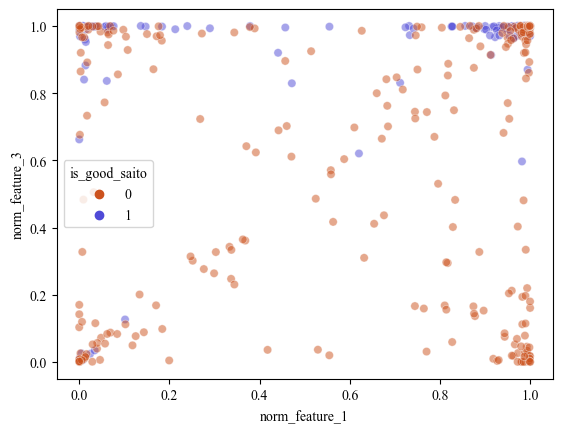

In [56]:
col1 = 'norm_feature_1'
col2 = 'norm_feature_3'

sns.scatterplot(x=col1, y=col2, hue=data['is_good_saito'], data=train_valid_X, palette=palette, alpha=0.5)
# sns.scatterplot(x=col1, y=col2, hue=data[''], data=data, palette=palette, alpha=0.5)



##### ▶KNN

In [4]:
from sklearn.neighbors import KNeighborsClassifier

### 変えないパラメータ ###
TRAIN_TEST_SPLIT_SEED = 1
KFOLD_SHUFFLE_SEED = 1
KFOLD_SHUFFLE_LABEL = 'saito_label'
Y_COL = 'is_good_saito'
K = 5
### パラメータの組み合わせ ###
ptcnt_type, ptcnt, input_col = 1, 7, 'startend_seg_cossim'
n_neighbors = 5

data = pd.read_csv(f'../temp/eachpt_feature/{ptcnt_type}_{ptcnt}_{input_col}.csv', delimiter=',', index_col=0)
X = data.copy()
y = data[Y_COL]
# 学習データとテストデータを725:310に分割する
train_valid, test, y_train_valid, y_test = train_test_split(X, y, train_size=725, shuffle=True, stratify=y, random_state=TRAIN_TEST_SPLIT_SEED)
    # K-Fold
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=KFOLD_SHUFFLE_SEED)
for k, (train_index, valid_index) in enumerate(skf.split(train_valid, train_valid[KFOLD_SHUFFLE_LABEL])):
        
    ### 訓練データと検証データに分ける ###
    train, valid = train_valid.iloc[train_index], train_valid.iloc[valid_index]
    
    ### 説明変数と目的変数に分ける ###
    X_col = [col for col in train_valid if 'feature_' in col]
    y_col = 'is_good_saito'
    train_X = train.copy()[X_col]
    train_y = train.copy()[y_col]
    valid_X = valid.copy()[X_col]
    valid_y = valid.copy()[y_col]
    
    ### 学習データのスケーリング(正規化, 学習データのmin, maxを検証データとテストデータに適用) ###
    # scaler = MinMaxScaler()
    scaler = StandardScaler()
    
    for col in train_X:
        train_minmax = scaler.fit(train_X[[col]])
        train_X[f'norm_{col}'] = scaler.transform(train_X[[col]])
        valid_X[f'norm_{col}'] = scaler.transform(valid_X[[col]])
        del train_X[col]
        del valid_X[col]

    ### モデルへの入力形式に変換する ###
    train_X = train_X.to_numpy()
    train_y = train_y.to_numpy()
    valid_X = valid_X.to_numpy()
    valid_y = valid_y.to_numpy()

    ### モデルを生成する ###
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    ### モデルを学習させる ###
    result = model.fit(train_X, train_y)
    ### 検証データで精度を算出する ###
    valid_pred = model.predict(valid_X)
    ### 各指標の値(validationデータに対する) ###
    recall = recall_score(valid_y, valid_pred, average=None)[1]
    precision = precision_score(valid_y, valid_pred, average=None)[1]
    f1 = f1_score(valid_y, valid_pred, average=None)[1]
    accuracy = accuracy_score(valid_y, valid_pred)

### 説明変数と目的変数に分ける ###
X_col = [col for col in train_valid if 'feature_' in col]
y_col = 'is_good_saito'
train_valid_X = train_valid.copy()[X_col]
train_valid_y = train_valid.copy()[y_col]
test_X = test.copy()[X_col]
test_y = test.copy()[y_col]

### 学習データのスケーリング(正規化, 学習データのmin, maxを検証データとテストデータに適用) ###
# scaler = MinMaxScaler()
scaler = StandardScaler()

for col in train_valid_X:
    train_minmax = scaler.fit(train_valid_X[[col]])
    train_valid_X[f'norm_{col}'] = scaler.transform(train_valid_X[[col]])
    test_X[f'norm_{col}'] = scaler.transform(test_X[[col]])
    del train_valid_X[col]
    del test_X[col]

### モデルへの入力形式に変換する ###
train_valid_X = train_valid_X.to_numpy()
train_valid_y = train_valid_y.to_numpy()
test_X = test_X.to_numpy()
test_y = test_y.to_numpy()

### モデルを生成する ###
model = KNeighborsClassifier(n_neighbors=n_neighbors)
### モデルを学習させる ###
result = model.fit(train_valid_X, train_valid_y)
### 検証データで精度を算出する ###
test_pred = model.predict(test_X)
### 各指標の値(testデータに対する) ###
recall = recall_score(test_y, test_pred, average=None)[1]
precision = precision_score(test_y, test_pred, average=None)[1]
f1 = f1_score(test_y, test_pred, average=None)[1]
accuracy = accuracy_score(test_y, test_pred)

print(f1)
print(recall)
print(precision) 

knn_pred = test_pred.copy()


0.9743589743589743
0.9844559585492227
0.9644670050761421


##### ▶LGR

In [59]:
from sklearn.linear_model import LogisticRegression

### 変えないパラメータ ###
TRAIN_TEST_SPLIT_SEED = 1
KFOLD_SHUFFLE_SEED = 1
KFOLD_SHUFFLE_LABEL = 'saito_label'
Y_COL = 'is_good_saito'
K = 5
### パラメータの組み合わせ ###
ptcnt_type, ptcnt, input_col = 2, 12, 'segment_cossim'
penalty, c, solver = 'l1', 100, 'liblinear'

data = pd.read_csv(f'../temp/eachpt_feature/{ptcnt_type}_{ptcnt}_{input_col}.csv', delimiter=',', index_col=0)
X = data.copy()
y = data[Y_COL]
# 学習データとテストデータを725:310に分割する
train_valid, test, y_train_valid, y_test = train_test_split(X, y, train_size=725, shuffle=True, stratify=y, random_state=TRAIN_TEST_SPLIT_SEED)
    # K-Fold
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=KFOLD_SHUFFLE_SEED)
for k, (train_index, valid_index) in enumerate(skf.split(train_valid, train_valid[KFOLD_SHUFFLE_LABEL])):
        
    ### 訓練データと検証データに分ける ###
    train, valid = train_valid.iloc[train_index], train_valid.iloc[valid_index]
    
    ### 説明変数と目的変数に分ける ###
    X_col = [col for col in train_valid if 'feature_' in col]
    y_col = 'is_good_saito'
    train_X = train.copy()[X_col]
    train_y = train.copy()[y_col]
    valid_X = valid.copy()[X_col]
    valid_y = valid.copy()[y_col]
    
    ### 学習データのスケーリング(正規化, 学習データのmin, maxを検証データとテストデータに適用) ###
    scaler = MinMaxScaler()
    for col in train_X:
        train_minmax = scaler.fit(train_X[[col]])
        train_X[f'norm_{col}'] = scaler.transform(train_X[[col]])
        valid_X[f'norm_{col}'] = scaler.transform(valid_X[[col]])
        del train_X[col]
        del valid_X[col]

    ### モデルへの入力形式に変換する ###
    train_X = train_X.to_numpy()
    train_y = train_y.to_numpy()
    valid_X = valid_X.to_numpy()
    valid_y = valid_y.to_numpy()

    ### モデルを生成する ###
    model = LogisticRegression(penalty=penalty, C=c, solver=solver)
    ### モデルを学習させる ###
    result = model.fit(train_X, train_y)
    ### 検証データで精度を算出する ###
    valid_pred = model.predict(valid_X)
    ### 各指標の値(validationデータに対する) ###
    recall = recall_score(valid_y, valid_pred, average=None)[1]
    precision = precision_score(valid_y, valid_pred, average=None)[1]
    f1 = f1_score(valid_y, valid_pred, average=None)[1]
    accuracy = accuracy_score(valid_y, valid_pred)

### 説明変数と目的変数に分ける ###
X_col = [col for col in train_valid if 'feature_' in col]
y_col = 'is_good_saito'
train_valid_X = train_valid.copy()[X_col]
train_valid_y = train_valid.copy()[y_col]
test_X = test.copy()[X_col]
test_y = test.copy()[y_col]

### 学習データのスケーリング(正規化, 学習データのmin, maxを検証データとテストデータに適用) ###
scaler = MinMaxScaler()
for col in train_valid_X:
    train_minmax = scaler.fit(train_valid_X[[col]])
    train_valid_X[f'norm_{col}'] = scaler.transform(train_valid_X[[col]])
    test_X[f'norm_{col}'] = scaler.transform(test_X[[col]])
    del train_valid_X[col]
    del test_X[col]

### モデルへの入力形式に変換する ###
train_valid_X = train_valid_X.to_numpy()
train_valid_y = train_valid_y.to_numpy()
test_X = test_X.to_numpy()
test_y = test_y.to_numpy()

### モデルを生成する ###
model = LogisticRegression(penalty=penalty, C=c, solver=solver)
### モデルを学習させる ###
result = model.fit(train_valid_X, train_valid_y)
### 検証データで精度を算出する ###
test_pred = model.predict(test_X)
### 各指標の値(testデータに対する) ###
recall = recall_score(test_y, test_pred, average=None)[1]
precision = precision_score(test_y, test_pred, average=None)[1]
f1 = f1_score(test_y, test_pred, average=None)[1]
accuracy = accuracy_score(test_y, test_pred)

print(f1)
print(recall)
print(precision)

lgr_pred = test_pred.copy()

0.9593908629441624
0.9792746113989638
0.9402985074626866


In [ ]:
0.9593908629441624
0.9792746113989638
0.9402985074626866

##### ▶RF

In [60]:
from sklearn.ensemble import RandomForestClassifier

### 変えないパラメータ ###
TRAIN_TEST_SPLIT_SEED = 1
KFOLD_SHUFFLE_SEED = 1
KFOLD_SHUFFLE_LABEL = 'saito_label'
Y_COL = 'is_good_saito'
K = 5
### パラメータの組み合わせ ###
ptcnt_type, ptcnt, input_col = 2, 52, 'startend_seg_cossim'
criterion = 'gini'
max_features = 'sqrt'
random_state = 1
n_estimators = 50
max_depth = 10
max_leaf_nodes = 10

data = pd.read_csv(f'../temp/eachpt_feature/{ptcnt_type}_{ptcnt}_{input_col}.csv', delimiter=',', index_col=0)
X = data.copy()
y = data[Y_COL]
# 学習データとテストデータを725:310に分割する
train_valid, test, y_train_valid, y_test = train_test_split(X, y, train_size=725, shuffle=True, stratify=y, random_state=TRAIN_TEST_SPLIT_SEED)
# K-Fold
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=KFOLD_SHUFFLE_SEED)
for k, (train_index, valid_index) in enumerate(skf.split(train_valid, train_valid[KFOLD_SHUFFLE_LABEL])):
        
    ### 訓練データと検証データに分ける ###
    train, valid = train_valid.iloc[train_index], train_valid.iloc[valid_index]
    
    ### 説明変数と目的変数に分ける ###
    X_col = [col for col in train_valid if 'feature_' in col]
    y_col = 'is_good_saito'
    train_X = train.copy()[X_col]
    train_y = train.copy()[y_col]
    valid_X = valid.copy()[X_col]
    valid_y = valid.copy()[y_col]
    
    ### 学習データのスケーリング(正規化, 学習データのmin, maxを検証データとテストデータに適用) ###
    scaler = MinMaxScaler()
    for col in train_X:
        train_minmax = scaler.fit(train_X[[col]])
        train_X[f'norm_{col}'] = scaler.transform(train_X[[col]])
        valid_X[f'norm_{col}'] = scaler.transform(valid_X[[col]])
        del train_X[col]
        del valid_X[col]

    ### モデルへの入力形式に変換する ###
    train_X = train_X.to_numpy()
    train_y = train_y.to_numpy()
    valid_X = valid_X.to_numpy()
    valid_y = valid_y.to_numpy()

    ### モデルを生成する ###
    model = RandomForestClassifier(
                criterion = criterion,
                max_features = max_features,
                random_state = random_state,
                n_estimators = n_estimators,
                max_depth = max_depth,
                max_leaf_nodes = max_leaf_nodes
            )
    ### モデルを学習させる ###
    result = model.fit(train_X, train_y)
    ### 検証データで精度を算出する ###
    valid_pred = model.predict(valid_X)
    ### 各指標の値(validationデータに対する) ###
    recall = recall_score(valid_y, valid_pred, average=None)[1]
    precision = precision_score(valid_y, valid_pred, average=None)[1]
    f1 = f1_score(valid_y, valid_pred, average=None)[1]
    accuracy = accuracy_score(valid_y, valid_pred)

### 説明変数と目的変数に分ける ###
X_col = [col for col in train_valid if 'feature_' in col]
y_col = 'is_good_saito'
train_valid_X = train_valid.copy()[X_col]
train_valid_y = train_valid.copy()[y_col]
test_X = test.copy()[X_col]
test_y = test.copy()[y_col]

### 学習データのスケーリング(正規化, 学習データのmin, maxを検証データとテストデータに適用) ###
scaler = MinMaxScaler()
for col in train_valid_X:
    train_minmax = scaler.fit(train_valid_X[[col]])
    train_valid_X[f'norm_{col}'] = scaler.transform(train_valid_X[[col]])
    test_X[f'norm_{col}'] = scaler.transform(test_X[[col]])
    del train_valid_X[col]
    del test_X[col]

### モデルへの入力形式に変換する ###
train_valid_X = train_valid_X.to_numpy()
train_valid_y = train_valid_y.to_numpy()
test_X = test_X.to_numpy()
test_y = test_y.to_numpy()

### モデルを生成する ###
model = RandomForestClassifier(
            criterion = criterion,
            max_features = max_features,
            random_state = random_state,
            n_estimators = n_estimators,
            max_depth = max_depth,
            max_leaf_nodes = max_leaf_nodes
        )
### モデルを学習させる ###
result = model.fit(train_valid_X, train_valid_y)
### 検証データで精度を算出する ###
test_pred = model.predict(test_X)
### 各指標の値(testデータに対する) ###
recall = recall_score(test_y, test_pred, average=None)[1]
precision = precision_score(test_y, test_pred, average=None)[1]
f1 = f1_score(test_y, test_pred, average=None)[1]
accuracy = accuracy_score(test_y, test_pred)

print(f1)
print(recall)
print(precision) 

rf_pred = test_pred.copy()

0.9633507853403142
0.9533678756476683
0.9735449735449735


In [ ]:
0.968421052631579
0.9533678756476683
0.983957219251337

##### ▶各手法の誤分類ストロークを調べる

In [62]:
test['svm_predict'] = svm_pred
test['knn_predict'] = knn_pred
test['lgr_predict'] = lgr_pred
test['rf_predict'] = rf_pred

test.to_csv('../temp/fail_classify_stroke.csv')

In [25]:
import os
import shutil

### SVM #########################
# FP
svm_fp = test.query('svm_predict == 1').query('is_good_saito == 0')
for i, row in svm_fp.iterrows():
    drawing_id = row['drawing_id']
    stroke_id = row['stroke_id']
    org_path = f'../data/stroke_img/{drawing_id}_{stroke_id}.png'
    new_path = shutil.copy(org_path, '../temp/fail_classify_stroke/svm/fp')
# FN
svm_fn = test.query('svm_predict == 0').query('is_good_saito == 1')
for i, row in svm_fn.iterrows():
    drawing_id = row['drawing_id']
    stroke_id = row['stroke_id']
    org_path = f'../data/stroke_img/{drawing_id}_{stroke_id}.png'
    new_path = shutil.copy(org_path, '../temp/fail_classify_stroke/svm/fn')
### KNN #########################
# FP
knn_fp = test.query('knn_predict == 1').query('is_good_saito == 0')
for i, row in knn_fp.iterrows():
    drawing_id = row['drawing_id']
    stroke_id = row['stroke_id']
    org_path = f'../data/stroke_img/{drawing_id}_{stroke_id}.png'
    new_path = shutil.copy(org_path, '../temp/fail_classify_stroke/knn/fp')
# FN
knn_fn = test.query('knn_predict == 0').query('is_good_saito == 1')
for i, row in knn_fn.iterrows():
    drawing_id = row['drawing_id']
    stroke_id = row['stroke_id']
    org_path = f'../data/stroke_img/{drawing_id}_{stroke_id}.png'
    new_path = shutil.copy(org_path, '../temp/fail_classify_stroke/knn/fn')
### LGR #########################
# FP
lgr_fp = test.query('lgr_predict == 1').query('is_good_saito == 0')
for i, row in lgr_fp.iterrows():
    drawing_id = row['drawing_id']
    stroke_id = row['stroke_id']
    org_path = f'../data/stroke_img/{drawing_id}_{stroke_id}.png'
    new_path = shutil.copy(org_path, '../temp/fail_classify_stroke/lgr/fp')
# FN
lgr_fn = test.query('lgr_predict == 0').query('is_good_saito == 1')
for i, row in lgr_fn.iterrows():
    drawing_id = row['drawing_id']
    stroke_id = row['stroke_id']
    org_path = f'../data/stroke_img/{drawing_id}_{stroke_id}.png'
    new_path = shutil.copy(org_path, '../temp/fail_classify_stroke/lgr/fn')
### RF #########################
# FP
rf_fp = test.query('rf_predict == 1').query('is_good_saito == 0')
for i, row in rf_fp.iterrows():
    drawing_id = row['drawing_id']
    stroke_id = row['stroke_id']
    org_path = f'../data/stroke_img/{drawing_id}_{stroke_id}.png'
    new_path = shutil.copy(org_path, '../temp/fail_classify_stroke/rf/fp')
# FN
rf_fn = test.query('rf_predict == 0').query('is_good_saito == 1')
for i, row in rf_fn.iterrows():
    drawing_id = row['drawing_id']
    stroke_id = row['stroke_id']
    org_path = f'../data/stroke_img/{drawing_id}_{stroke_id}.png'
    new_path = shutil.copy(org_path, '../temp/fail_classify_stroke/rf/fn')

##### ▶形状を確認する

In [28]:
data = pd.read_pickle('../data/shape_groundtruth_data.pkl')

In [41]:
stroke = data.query('drawing_id == 959').query('stroke_id == 1782')

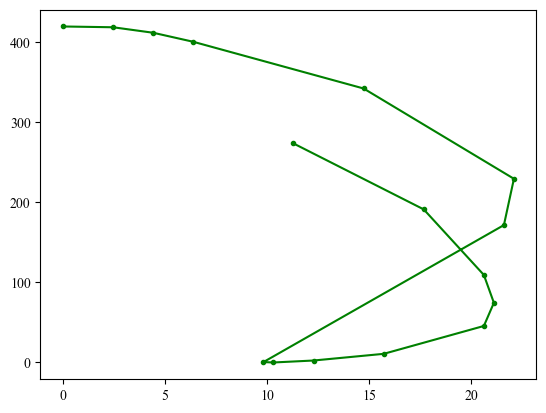

In [42]:
plt.plot(stroke['normalized_x'].iloc[-1], stroke['normalized_y'].iloc[-1], color='green', marker='.')